# 0. Import Data From Kilosort

## 0.0 Preliminaries

In [1]:
import os
import math
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib.colors import ListedColormap

## 0.1 Function to imports the features of the kilosort output I use most.

In [2]:
def importKS(folderpath,depth=250,sampleRate=30000):
    clusterInfo = pd.read_csv(folderpath+'/cluster_info.tsv',sep='\t')
    spikeClusters = np.load(folderpath+'/spike_clusters.npy')
    spikeTimes = np.load(folderpath+'/spike_times.npy')

    # assign the manually-sorted label back to KSLable
    clusterInfo.loc[clusterInfo['group'] == 'good', 'KSLabel'] = 'good'

    try:
        good_ids = np.array(clusterInfo['id'][clusterInfo['KSLabel'] == 'good'])
    except KeyError:
        good_ids = np.array(clusterInfo['cluster_id'][clusterInfo['KSLabel'] == 'good'])
    
    # write the output
    outDict = {}
    outDict['goodSpikes'] = spikeClusters[np.array([n in good_ids for n in spikeClusters])]
    outDict['goodSamples'] = np.int64(spikeTimes[np.array([n in good_ids for n in spikeClusters])].reshape(-1))
    outDict['goodTimes'] = outDict['goodSamples']/sampleRate
    outDict['sampleRate'] = sampleRate
    outDict['depth'] = clusterInfo['depth']
    outDict['clusterID'] = clusterInfo['cluster_id'] ## to get a list of cluster ids
    outDict['nSpikes'] = clusterInfo['n_spikes'] ## to get number of spikes 
    outDict['depthIndices'] = np.argsort(clusterInfo['depth']) ## to get an index to use for sorting by depth
    outDict['goodIDs'] = good_ids # to get the good IDs

    # print the number of good neurons
    print("There are {} neurons that pass the quality check.".format(len(good_ids)))

    # report the sampling frequency
    print("The sampling frequency is {} Hz.".format(outDict['sampleRate']))
    
    return outDict

## 0.2 Plot the Population Spike Train of S1 Neurons

In [3]:
# define the directory containing data files
#folder_path = '/Users/ronghaozhang/Documents/03_Github_Repositories/BMED7610_NP-S1/data/03_SpontForePaw/'
#folder_path = '/Users/helen/Documents/GitHub/s1-spik-pixel/data/03_SpontForePaw'
folder_path = '/Users/neelh/Documents/GitHub Repositories/s1-spik-pixel/data/03_SpontForePaw'

# visualize
files = os.listdir(folder_path)
print(files)

# import data
data = importKS(folder_path)

['cluster_info.tsv', 'spike_clusters.npy', 'spike_times.npy']
There are 173 neurons that pass the quality check.
The sampling frequency is 30000 Hz.


`outDict['goodSamples']` contains the units (with good quality) where spikes come from.
`outDict['goodSpikes']` contains the time of all the spiking activities.

Text(0.5, 1.0, 'Population Spike Train of S1 Neurons During Spontaneous Activity of Mice')

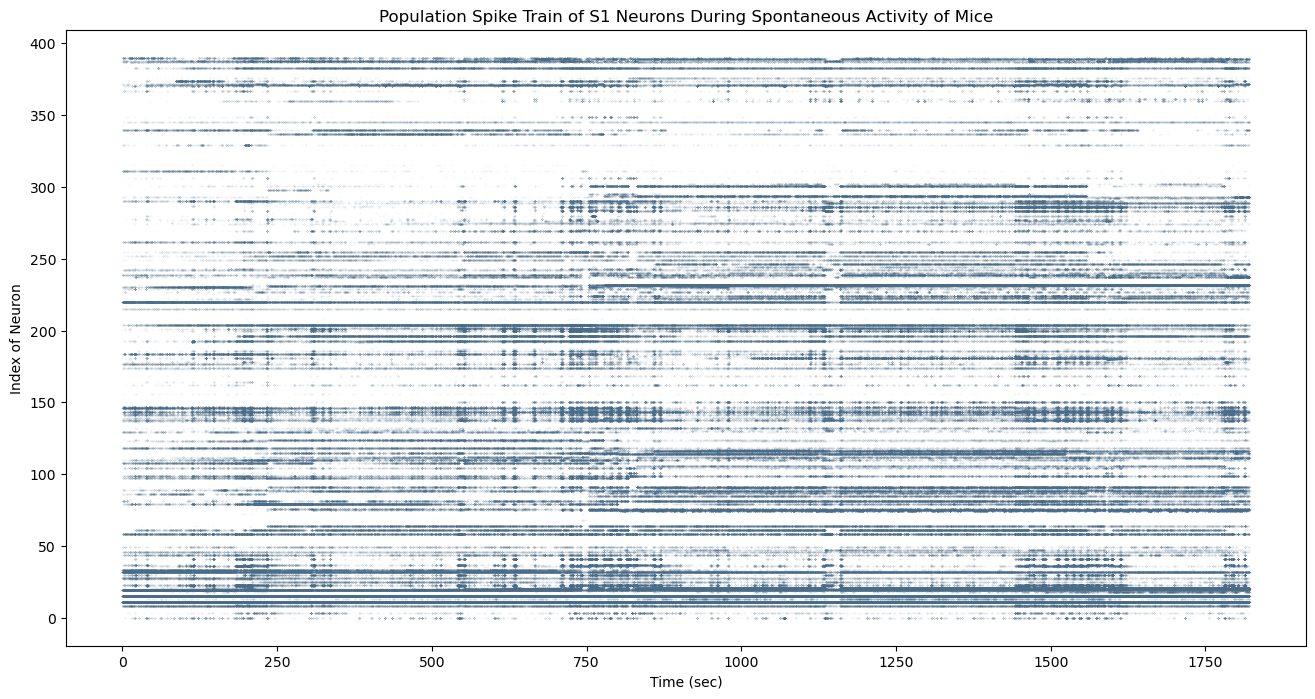

In [4]:
# Plot the population spike train
plt.figure(figsize=(16, 8))

plt.plot(data['goodTimes'], data['goodSpikes'], '.', alpha = 0.2, markersize = 0.3, color = "#496C8888")

plt.xlabel("Time (sec)")
plt.ylabel("Index of Neuron")
plt.title("Population Spike Train of S1 Neurons During Spontaneous Activity of Mice")

# 1. Plot the Heatmap

1. `FirePattern` is a matrix that has the dimension of x: Spike Number Per timestep and y: number of high-quality units. 
2. `data['goodIDs']` is the sorted cluster index of good units. `goodIdx` is the number of good units.
3. Current Time Step set to 1.0 second.

In [5]:
dt = 1; 
nSample = math.ceil(np.max(data['goodTimes'])/dt)  # number of sampling point
goodIdx = len(data['goodIDs']) # cluster index of good units

# Calculate the firing pattern per time step
FirePattern = np.zeros([goodIdx, nSample]) 

for i in range(len(data['goodSpikes'])):
    xIdx = np.where(data['goodIDs'] == data['goodSpikes'][i])
    yIdx = math.floor(data['goodTimes'][i]/dt)
    FirePattern[xIdx, yIdx] += 1

# Normalize the firing pattern (Delta Spike)
baseFire = np.mean(FirePattern, axis=1)
baseFire = baseFire[:, np.newaxis] # Reshape baseFire to make it compatible for broadcasting

NormFire = FirePattern - baseFire

This recording is from mouse BCF2. At time period 3min - 6min, 12min - 15min, 24min - 27min, the righe forepaw is stimulated. Therefore, I created an array `isStim`, where `0` represents spontaneous activity, and `1` represents active stimuli of right forepaw.

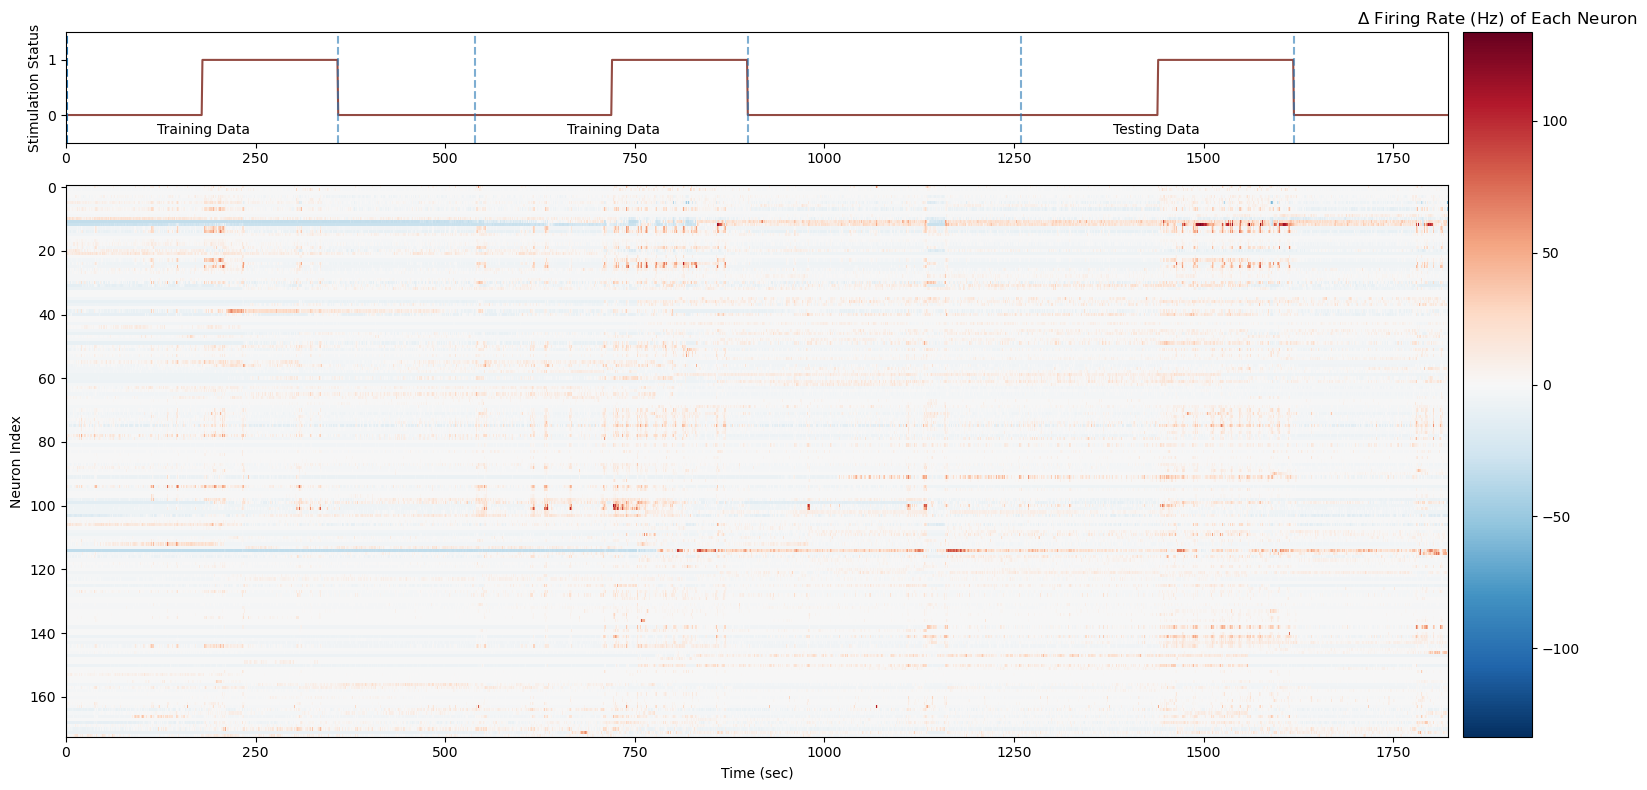

In [6]:
isStim = np.zeros([1,NormFire.shape[1]])
isStim[0,round(3*60/dt):round(6*60/dt-1)] = 1
isStim[0,round(12*60/dt):round(15*60/dt-1)] = 1
isStim[0,round(24*60/dt):round(27*60/dt-1)] = 1

fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 5])

# stimulation status
ax0 = plt.subplot(gs[0, 0])
ax0.plot(isStim.T, color="#934B43FF")
ax0.set_xlim([0,isStim.shape[1]])
ax0.set_ylim([-0.5, 1.5])
ax0.axvline(x = 1, color='#2878B5', linestyle='--')
ax0.axvline(x = 6*60-1, color='#2878B599', linestyle='--')
ax0.axvline(x = 9*60-1, color='#2878B599', linestyle='--')
ax0.axvline(x = 15*60-1, color='#2878B599', linestyle='--')
ax0.axvline(x = 21*60-1, color='#2878B599', linestyle='--')
ax0.axvline(x = 27*60-1, color='#2878B599', linestyle='--')
ax0.text(2*60, -0.35, r'Training Data')
ax0.text(11*60, -0.35, r'Training Data')
ax0.text(23*60, -0.35, r'Testing Data')
ax0.set_ylabel('Stimulation Status')

# delta spike of firing pattern
ax1 = plt.subplot(gs[1, 0])
im = ax1.imshow(NormFire, interpolation='none', cmap='RdBu
_r', aspect='auto',
                vmin=-np.max(np.abs(NormFire)), vmax=np.max(np.abs(NormFire)))
ax1.set_xlim([0,isStim.shape[1]])

ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Neuron Index')

# Colorbar in a separate subplot to match the width of the other plots
cbar_ax = plt.subplot(gs[:, 1])
fig.colorbar(im, cax=cbar_ax)
plt.title("$\Delta$ Firing Rate (Hz) of Each Neuron")
plt.tight_layout()
plt.show()

# 2. K-Means Clustering of Neurons

## 2.1 Split and Plot Training and Testing Data

In [34]:
sponTrain = np.concatenate((NormFire[:, 0:int(np.round(3*60/dt))-1], 
                            NormFire[:, int(np.round(9*60/dt)):int(np.round(12*60/dt))-1]), axis=1)
actvTrain = np.concatenate((NormFire[:, int(np.round(3*60/dt)):int(np.round(6*60/dt))-1], 
                            NormFire[:, int(np.round(12*60/dt)):int(np.round(15*60/dt))-1]), axis=1)

sponTest = NormFire[:, int(np.round(21*60/dt)):int(np.round(24*60/dt))-1]
actvTest = NormFire[:, int(np.round(24*60/dt)):int(np.round(27*60/dt))-1]

sponTrainMean, actvTrainMean = np.mean(sponTrain,axis=1), np.mean(actvTrain,axis=1)
sponTestMean, actvTestMean = np.mean(sponTest,axis=1), np.mean(actvTest,axis=1)

seed = 7610

# Define Clusters 
def ClusterFire(sponMean, actvMean, k):
    dist = actvMean - sponMean
    
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=seed)
    distaNew = np.reshape(dist, (-1, 1))
    kmeans.fit(distaNew)

    return kmeans.labels_

# Function to Create Histogram Dataset
def GetHist(data, assignClust, kNum): 
    dataGrp = []; 
    for k in range(kNum):
        dataGrp.append(data[np.where(assignClust == k)])
    return dataGrp

# Create Training Data Label
labelTr = ClusterFire(sponTrainMean, actvTrainMean, k = 4)
labelTr[labelTr == 2] = 1
labelTr[labelTr == 3] = 2
# Create Testing Data Label
labelTe = ClusterFire(sponTestMean, actvTestMean, k = 4)
labelTe[labelTe == 2] = 0
labelTe[labelTe == 3] = 2


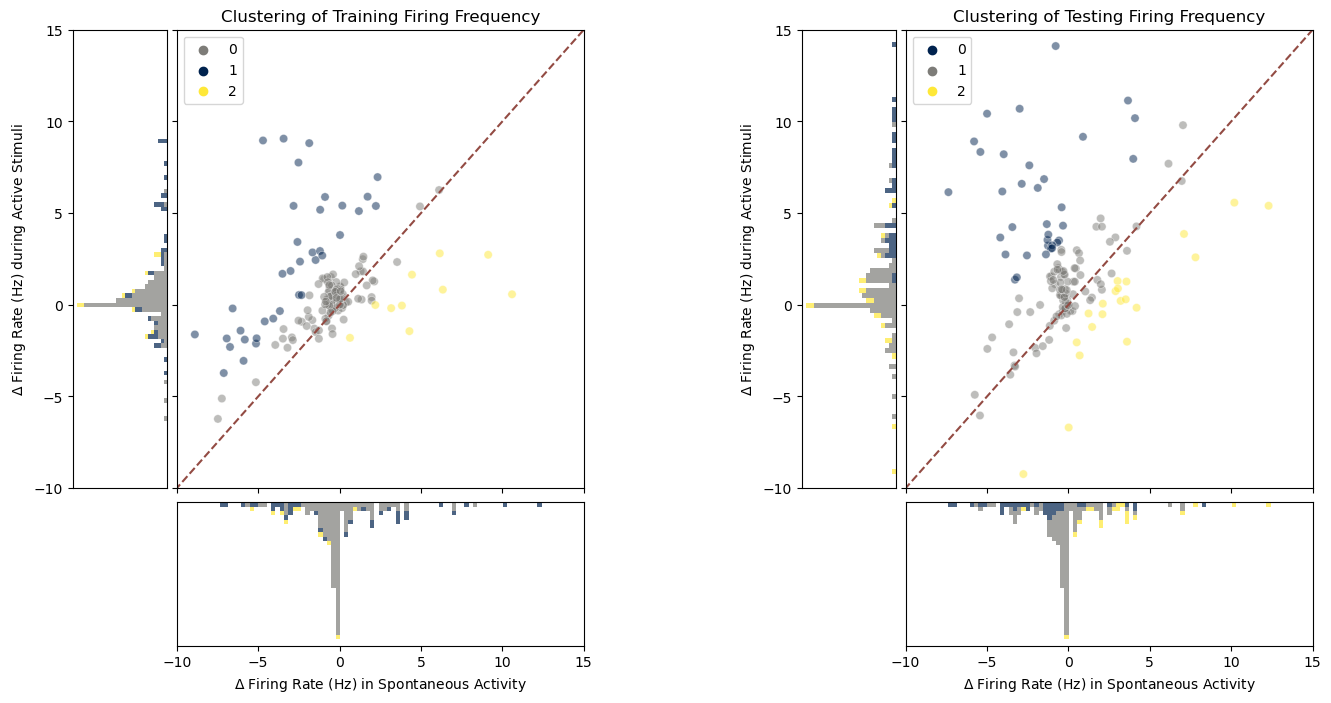

In [35]:
# set up the figure grid
fig = plt.figure(figsize=(16, 8)) 
grid = plt.GridSpec(4, 12, hspace=0.1, wspace=0.1) 

civiCol = cm.cividis(np.linspace(0, 1, 3))
civiColX = [civiCol[1],civiCol[0],civiCol[2]]
# plot the training fire freq
scTr = fig.add_subplot(grid[:-1, 1:5])
yhisTr = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey = scTr)
xhisTr = fig.add_subplot(grid[-1, 1:5], yticklabels=[], sharex = scTr)

# scatter plot of training dataset
scatterTr = sns.scatterplot(x=sponTrainMean, y=actvTrainMean, hue = labelTr, ax=scTr, palette=civiColX, alpha = 0.5)
scatterTr.tick_params(labelleft = False, labelbottom=False) 

scTr.plot([-50, 50], [-50, 50], color='#934B43', linestyle='--')

# x-axis histogram
xhisDep = GetHist(sponTestMean, labelTr, kNum = 3)
xhisTr.hist(xhisDep, bins=100, orientation='vertical',stacked=True, color = civiColX, alpha = 0.7)
xhisTr.invert_yaxis()
xhisTr.set_xlabel("$\Delta$ Firing Rate (Hz) in Spontaneous Activity")
xhisTr.tick_params(axis='both', which='both', left=False, labelleft=False)

# y-axis histogram
yhisDep = GetHist(actvTrainMean, labelTr, kNum = 3)
yhisTr.hist(yhisDep, bins=100, orientation='horizontal',stacked=True, color = civiColX, alpha = 0.7)
yhisTr.invert_xaxis()
yhisTr.tick_params(axis='both', which='both', bottom=False, labelbottom=False) 
yhisTr.set_ylabel("$\Delta$ Firing Rate (Hz) during Active Stimuli")

scatterTr.set_xlim([-10,15])
scatterTr.set_ylim([-10,15])
scatterTr.set_title("Clustering of Training Firing Frequency")

# plot the testing fire freq
scTe = fig.add_subplot(grid[:-1, 8:12])
yhisTe = fig.add_subplot(grid[:-1, 7], xticklabels=[], sharey=scTe)
xhisTe = fig.add_subplot(grid[-1, 8:12], yticklabels=[], sharex=scTe)

# scatter plot of testing dataset
scatterTe = sns.scatterplot(x=sponTestMean, y=actvTestMean, hue = labelTe, ax=scTe, palette='cividis', alpha = 0.5)
scatterTe.tick_params(labelleft = False, labelbottom=False) 

scTe.plot([-50, 50], [-50, 50], color='#934B43', linestyle='--')

# x-axis histogram
xhisDep = GetHist(sponTestMean, labelTe, kNum = 3)
xhisTe.hist(xhisDep, bins=100, orientation='vertical',stacked=True, color = civiCol, alpha = 0.7)
xhisTe.invert_yaxis()
xhisTe.set_xlabel("$\Delta$ Firing Rate (Hz) in Spontaneous Activity")
xhisTe.tick_params(axis='both', which='both', left=False, labelleft=False)

# y-axis histogram
yhisDep = GetHist(actvTestMean, labelTe, kNum = 3)
yhisTe.hist(yhisDep, bins=200, orientation='horizontal',stacked=True, color = civiCol, alpha = 0.7)
yhisTe.invert_xaxis()
yhisTe.tick_params(axis='both', which='both', bottom=False, labelbottom=False) 
yhisTe.set_ylabel("$\Delta$ Firing Rate (Hz) during Active Stimuli")

scatterTe.set_xlim([-10,15])
scatterTe.set_ylim([-10,15])
scatterTe.set_title("Clustering of Testing Firing Frequency")

plt.show()

## 2.2 Map to Site Depth

In [36]:
def ClusterDepth(goodDep, k):
    
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=seed)
    goodDep = np.reshape(goodDep, (-1, 1))
    kmeans.fit(goodDep)

    return kmeans.labels_

1. `data['depth']`: For all clusters, index from 0 to length(clusters), and list all the depth. 
2. `data['clusterID']`: For all clusters, index from 0 to length(clusters), and list cluster ID. 
3. `data['goodIDs']`: For all clusters, index from 0 to length(good clusters), and list all cluster ID.

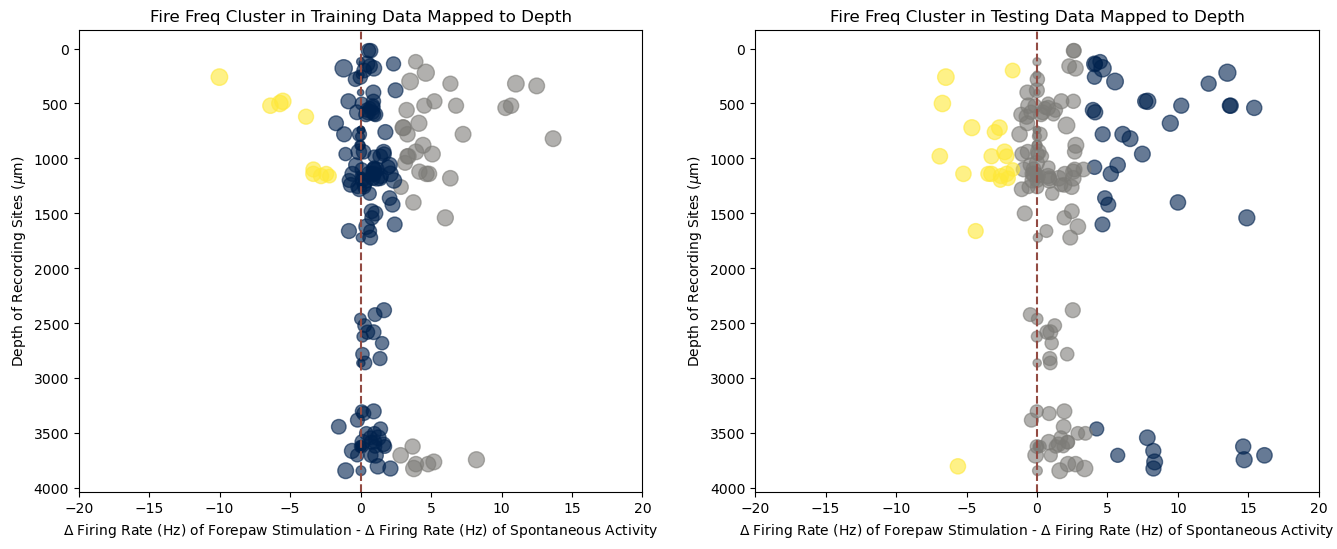

In [37]:
# compute the good depth
goodDepIdx = np.where(np.isin(np.array(data['clusterID']),np.array(data['goodIDs'])))
goodDep = np.array(data['depth'])[goodDepIdx]
goodNSpk = np.array(data['nSpikes'])[goodDepIdx]
# compute the Firing Difference vector 
FireDiffTr = actvTrainMean - sponTrainMean
FireDiffTe = actvTestMean  - sponTestMean

depPlotData = {'dep': goodDep, 
               'train': FireDiffTr, 
               'test': FireDiffTe, 
               'trClust': labelTr ,
               'teClust': labelTe, 
               'depClust': ClusterDepth(goodDep, 4),
               'nSpk': np.log10(goodNSpk)*30}

# Plot the Histogram to analyze their depth
plt.figure(figsize=(16, 6)) 

plt.subplot(1, 2, 1)
plt.scatter('train','dep', c='trClust', s='nSpk', data = depPlotData, cmap='cividis',alpha = 0.6)
plt.axvline(x = 0, color='#934B43', linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel("$\Delta$ Firing Rate (Hz) of Forepaw Stimulation - $\Delta$ Firing Rate (Hz) of Spontaneous Activity")
plt.ylabel("Depth of Recording Sites ($\mu$m)")
plt.title("Fire Freq Cluster in Training Data Mapped to Depth")
plt.xlim([-20,20])

plt.subplot(1, 2, 2)
plt.scatter('test','dep', c='teClust', s='nSpk', data = depPlotData, cmap='cividis',alpha = 0.6)
plt.axvline(x = 0, color='#934B43', linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel("$\Delta$ Firing Rate (Hz) of Forepaw Stimulation - $\Delta$ Firing Rate (Hz) of Spontaneous Activity")
plt.ylabel("Depth of Recording Sites ($\mu$m)")
plt.title("Fire Freq Cluster in Testing Data Mapped to Depth")
plt.xlim([-20,20])

plt.show()

# 3. Clustering of Neuron Depth

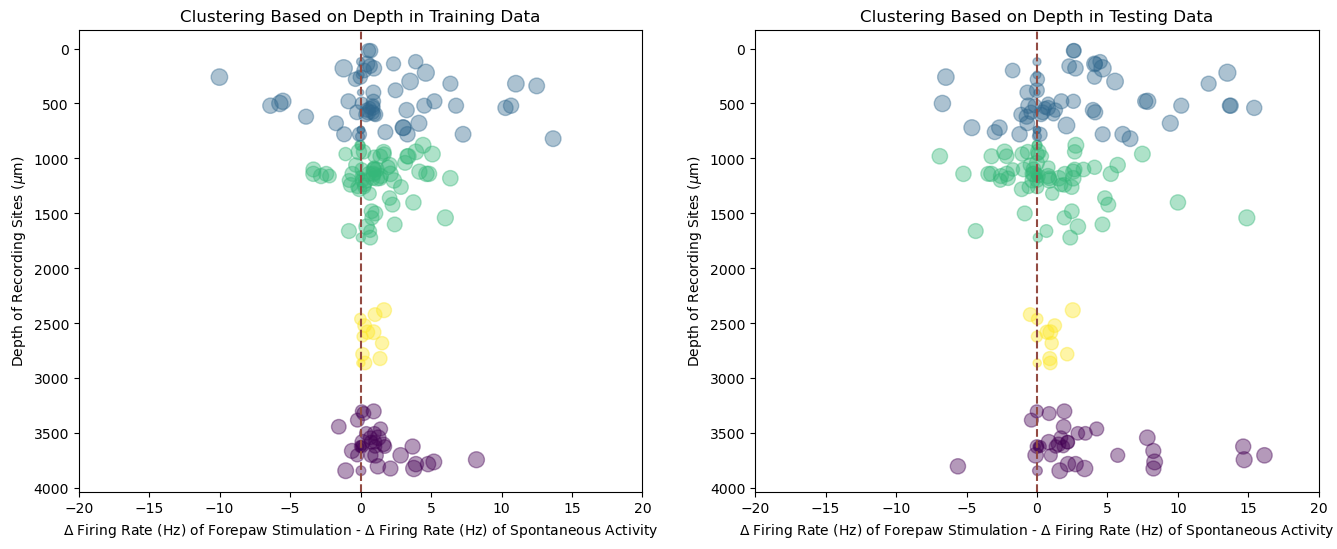

In [38]:
# Plot the Histogram to analyze their depth
plt.figure(figsize=(16, 6)) 

plt.subplot(1, 2, 1)
plt.scatter('train','dep', c='depClust', s='nSpk', data = depPlotData, cmap='viridis',alpha = 0.4)
plt.axvline(x = 0, color='#934B43', linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel("$\Delta$ Firing Rate (Hz) of Forepaw Stimulation - $\Delta$ Firing Rate (Hz) of Spontaneous Activity")
plt.ylabel("Depth of Recording Sites ($\mu$m)")
plt.title("Clustering Based on Depth in Training Data")
plt.xlim([-20,20])

plt.subplot(1, 2, 2)
plt.scatter('test','dep', c='depClust', s='nSpk', data = depPlotData, cmap='viridis',alpha = 0.4)
plt.axvline(x = 0, color='#934B43', linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel("$\Delta$ Firing Rate (Hz) of Forepaw Stimulation - $\Delta$ Firing Rate (Hz) of Spontaneous Activity")
plt.ylabel("Depth of Recording Sites ($\mu$m)")
plt.title("Clustering Based on Depth in Testing Data")
plt.xlim([-20,20])

plt.show()

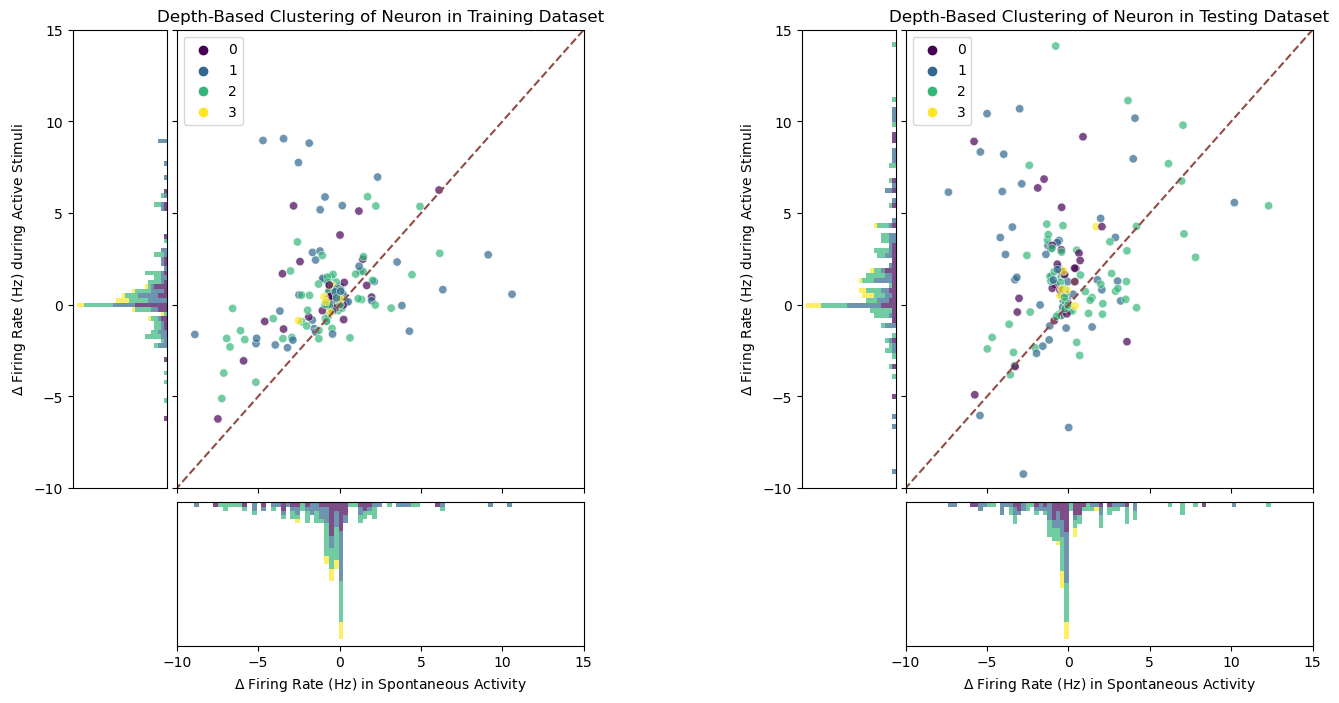

In [39]:
# set up the figure grid
fig = plt.figure(figsize=(16, 8)) 
grid = plt.GridSpec(4, 12, hspace=0.1, wspace=0.1) 

viridisCol = cm.viridis(np.linspace(0, 1, 4))

# plot the training fire freq
scTr = fig.add_subplot(grid[:-1, 1:5])
yhisTr = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey = scTr)
xhisTr = fig.add_subplot(grid[-1, 1:5], yticklabels=[], sharex = scTr)

# scatter plot of training dataset
scatterTr = sns.scatterplot(x=sponTrainMean, y=actvTrainMean, hue = depPlotData['depClust'], ax=scTr, palette='viridis', alpha = 0.7)
scatterTr.tick_params(labelleft = False, labelbottom=False) 

scTr.plot([-50, 50], [-50, 50], color='#934B43', linestyle='--')

# x-axis histogram
xhisDep = GetHist(sponTrainMean, depPlotData['depClust'], kNum = 4)
xhisTr.hist(xhisDep, bins=150, orientation='vertical',stacked=True, color = viridisCol, alpha = 0.7)
xhisTr.invert_yaxis()
xhisTr.set_xlabel("$\Delta$ Firing Rate (Hz) in Spontaneous Activity")
xhisTr.tick_params(axis='both', which='both', left=False, labelleft=False)

# y-axis histogram
yhisDep = GetHist(actvTrainMean, depPlotData['depClust'], kNum = 4)
yhisTr.hist(yhisDep, bins=100, orientation='horizontal',stacked=True, color = viridisCol, alpha = 0.7)
yhisTr.invert_xaxis()
yhisTr.tick_params(axis='both', which='both', bottom=False, labelbottom=False) 
yhisTr.set_ylabel("$\Delta$ Firing Rate (Hz) during Active Stimuli")

scatterTr.set_xlim([-10,15])
scatterTr.set_ylim([-10,15])
scatterTr.set_title("Depth-Based Clustering of Neuron in Training Dataset")

# plot the testing fire freq
scTe = fig.add_subplot(grid[:-1, 8:12])
yhisTe = fig.add_subplot(grid[:-1, 7], xticklabels=[], sharey=scTe)
xhisTe = fig.add_subplot(grid[-1, 8:12], yticklabels=[], sharex=scTe)

# scatter plot of testing dataset
scatterTe = sns.scatterplot(x=sponTestMean, y=actvTestMean, hue = depPlotData['depClust'], ax=scTe, palette='viridis', alpha = 0.7)
scatterTe.tick_params(labelleft = False, labelbottom=False) 

scTe.plot([-50, 50], [-50, 50], color='#934B43', linestyle='--')

# x-axis histogram
xhisDep = GetHist(sponTestMean, depPlotData['depClust'], kNum = 4)
xhisTe.hist(xhisDep, bins=100, orientation='vertical',stacked=True, color = viridisCol, alpha = 0.7)
xhisTe.invert_yaxis()
xhisTe.set_xlabel("$\Delta$ Firing Rate (Hz) in Spontaneous Activity")
xhisTe.tick_params(axis='both', which='both', left=False, labelleft=False)

# y-axis histogram
yhisDep = GetHist(actvTestMean, depPlotData['depClust'], kNum = 4)
yhisTe.hist(yhisDep, bins=200, orientation='horizontal',stacked=True, color = viridisCol, alpha = 0.7)
yhisTe.invert_xaxis()
yhisTe.tick_params(axis='both', which='both', bottom=False, labelbottom=False) 
yhisTe.set_ylabel("$\Delta$ Firing Rate (Hz) during Active Stimuli")

scatterTe.set_xlim([-10,15])
scatterTe.set_ylim([-10,15])
scatterTe.set_title("Depth-Based Clustering of Neuron in Testing Dataset")

plt.show()

# 4. LDA Classification 

In this section, we took the first 2 pairs of spontaneous activity and active stimuli as training data, and the last pair as testing data. We perform a Linear Discriminant Analysis (LDA) to predict the presence of active stimuli based on neural activities. 

In [43]:
dt = 2

nSample = math.ceil(np.max(data['goodTimes'])/dt)  # number of sampling point
goodIdx = len(data['goodIDs']) # cluster index of good units

# Calculate the firing pattern per time step
FirePattern = np.zeros([goodIdx, nSample]) 

for i in range(len(data['goodSpikes'])):
    xIdx = np.where(data['goodIDs'] == data['goodSpikes'][i])
    yIdx = math.floor(data['goodTimes'][i]/dt)
    FirePattern[xIdx, yIdx] += 1

# Normalize the firing pattern (Delta Spike)
baseFire = np.mean(FirePattern, axis=1)
baseFire = baseFire[:, np.newaxis] # Reshape baseFire to make it compatible for broadcasting

NormFire = FirePattern - baseFire

sponTrain = np.concatenate((NormFire[:, 0:int(np.round(3*60/dt))-1], 
                            NormFire[:, int(np.round(9*60/dt)):int(np.round(12*60/dt))-1]), axis=1)
actvTrain = np.concatenate((NormFire[:, int(np.round(3*60/dt)):int(np.round(6*60/dt))-1], 
                            NormFire[:, int(np.round(12*60/dt)):int(np.round(15*60/dt))-1]), axis=1)

sponTest = NormFire[:, int(np.round(21*60/dt)):int(np.round(24*60/dt))-1]
actvTest = NormFire[:, int(np.round(24*60/dt)):int(np.round(27*60/dt))-1]

# Dataset Preparation for Classification
## output datasets
outTrain = np.ones([1,sponTrain.shape[1]+actvTrain.shape[1]])[0,:]
outTrain[0:(sponTrain.shape[1])] = 0 

outTest = np.ones([1,sponTest.shape[1]+actvTest.shape[1]])[0,:]
outTest[0:(sponTest.shape[1])] = 0 

## input datasets
inTrain = np.transpose(np.concatenate((sponTrain, actvTrain),axis = 1))
inTest = np.transpose(np.concatenate((sponTest, actvTest), axis = 1))

# fit LDA model
lda = LDA()
lda.fit(inTrain, outTrain)

# predict the testing 
outPred = lda.predict(inTest)

accuracy = accuracy_score(outPred, outTest)
print(f'Accuracy: {accuracy:.8f}')

# dimensionality reduction
#X_reduced = lda.transform(inTrain)



Accuracy: 0.67977528


In [53]:
seq1, seq2 = inTrain, outTrain
grid1, grid2 = np.meshgrid(np.arange(start = seq1[:, 0].min() - 1, stop = seq1[:, 0].max() + 1, step = 0.01),
                     np.arange(start = seq1[:, 1].min() - 1, stop = seq1[:, 1].max() + 1, step = 0.01))
print(inTrain)
print(grid1)
plt.contourf(grid1, grid2, lda.predict(np.array([grid1.ravel(), grid2.ravel()]).T).reshape(grid1.shape),
             alpha = 0.75, cmap = ListedColormap(('lightblue', 'peachpuff', 'mistyrose')))
# plt.xlim(grid1.min(), grid1.max())
# plt.ylim(grid2.min(), grid2.max())
# for key, value in enumerate(np.unique(seq2)):
#     plt.scatter(seq1[seq2 == value, 0], seq1[seq2 == value, 1],
#                 c = ListedColormap(('mediumturquoise', 'lightsalmon', 'lightcoral'))(key), label = value)
# plt.title('Training set')
# plt.xlabel('LDA1')
# plt.ylabel('LDA2')
# plt.legend()
# plt.savefig('output/1_training.png')
# plt.show()

[[-4.12623491e+00 -3.90010977e+00 -1.42700329e-02 ... -8.50384193e+00
  -1.49363337e+01  1.11734358e+01]
 [-4.12623491e+00 -3.90010977e+00 -1.42700329e-02 ... -8.50384193e+00
  -1.49363337e+01  7.17343578e+00]
 [-2.12623491e+00 -3.90010977e+00 -1.42700329e-02 ... -6.50384193e+00
  -1.49363337e+01  4.17343578e+00]
 ...
 [-4.12623491e+00  5.09989023e+00 -1.42700329e-02 ... -1.25038419e+01
   6.06366630e+00 -4.82656422e+00]
 [-4.12623491e+00 -1.90010977e+00 -1.42700329e-02 ... -1.35038419e+01
   9.06366630e+00  1.73435785e-01]
 [-4.12623491e+00 -2.90010977e+00 -1.42700329e-02 ... -1.25038419e+01
   1.40636663e+01 -4.82656422e+00]]
[[-5.12623491 -5.11623491 -5.10623491 ... 72.84376509 72.85376509
  72.86376509]
 [-5.12623491 -5.11623491 -5.10623491 ... 72.84376509 72.85376509
  72.86376509]
 [-5.12623491 -5.11623491 -5.10623491 ... 72.84376509 72.85376509
  72.86376509]
 ...
 [-5.12623491 -5.11623491 -5.10623491 ... 72.84376509 72.85376509
  72.86376509]
 [-5.12623491 -5.11623491 -5.106234

ValueError: X has 2 features, but LinearDiscriminantAnalysis is expecting 173 features as input.

In [47]:
seq1, seq2 = inTest, outTest
grid1, grid2 = np.meshgrid(np.arange(start = seq1[:, 0].min() - 1, stop = seq1[:, 0].max() + 1, step = 0.01),
                     np.arange(start = seq1[:, 1].min() - 1, stop = seq1[:, 1].max() + 1, step = 0.01))
plt.contourf(grid1, grid2, lda.predict(np.array([grid1.ravel(), grid2.ravel()]).T).reshape(grid1.shape),
             alpha = 0.75, cmap = ListedColormap(('lightblue', 'peachpuff', 'mistyrose')))
plt.xlim(grid1.min(), grid1.max())
plt.ylim(grid2.min(), grid2.max())
for key, value in enumerate(np.unique(seq2)):
    plt.scatter(seq1[seq2 == value, 0], seq1[seq2 == value, 1],
                c = ListedColormap(('mediumturquoise', 'lightsalmon', 'lightcoral'))(key), label = value)
plt.title('Test set')
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.legend()
plt.savefig('output/2_testing.png')
plt.show()

ValueError: X has 2 features, but LinearDiscriminantAnalysis is expecting 173 features as input.